### libs

In [53]:
from torchvision.datasets import CelebA
import os
import torch.nn as nn
import glob
import os
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch
import math
# main libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.nn import functional as F
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import math
import torchvision.transforms.functional as TF
import cv2
from keras.utils import image_dataset_from_directory
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.nn.parameter import Parameter

from torch.nn import init
from torchvision.utils import make_grid
from collections import OrderedDict

import torch
from torch.utils.data import Dataset

from skimage import transform
import skimage.io as io
import numpy as np
from torchvision.utils import save_image

In [54]:
import math
import pdb
import torch
import torch.nn as nn
import torch.nn.functional as F


class Morphology(nn.Module):
    '''
    Base class for morpholigical operators
    For now, only supports stride=1, dilation=1, kernel_size H==W, and padding='same'.
    '''
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=15, type=None):
        '''
        in_channels: scalar
        out_channels: scalar, the number of the morphological neure.
        kernel_size: scalar, the spatial size of the morphological neure.
        soft_max: bool, using the soft max rather the torch.max(), ref: Dense Morphological Networks: An Universal Function Approximator (Mondal et al. (2019)).
        beta: scalar, used by soft_max.
        type: str, dilation2d or erosion2d.
        '''
        super(Morphology, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.soft_max = soft_max
        self.beta = beta
        self.type = type

        self.weight = nn.Parameter(torch.zeros(out_channels, in_channels, kernel_size, kernel_size), requires_grad=True)
        self.unfold = nn.Unfold(kernel_size, dilation=1, padding=0, stride=1)

    def forward(self, x):
        '''
        x: tensor of shape (B,C,H,W)
        '''
        # padding
        x = fixed_padding(x, self.kernel_size, dilation=1)

        # unfold
        x = self.unfold(x)  # (B, Cin*kH*kW, L), where L is the numbers of patches
        x = x.unsqueeze(1)  # (B, 1, Cin*kH*kW, L)
        L = x.size(-1)
        L_sqrt = int(math.sqrt(L))

        # erosion
        weight = self.weight.view(self.out_channels, -1) # (Cout, Cin*kH*kW)
        weight = weight.unsqueeze(0).unsqueeze(-1)  # (1, Cout, Cin*kH*kW, 1)

        if self.type == 'erosion2d':
            x = weight - x # (B, Cout, Cin*kH*kW, L)
        elif self.type == 'dilation2d':
            x = weight + x # (B, Cout, Cin*kH*kW, L)
        else:
            raise ValueError

        if not self.soft_max:
            x, _ = torch.max(x, dim=2, keepdim=False) # (B, Cout, L)
        else:
            x = torch.logsumexp(x*self.beta, dim=2, keepdim=False) / self.beta # (B, Cout, L)

        if self.type == 'erosion2d':
            x = -1 * x

        # instead of fold, we use view to avoid copy
        x = x.view(-1, self.out_channels, L_sqrt, L_sqrt)  # (B, Cout, L/2, L/2)

        return x

class Dilation2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Dilation2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'dilation2d')

class Erosion2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Erosion2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'erosion2d')



def fixed_padding(inputs, kernel_size, dilation):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (dilation - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs


if __name__ == '__main__':
    # test
    x=torch.randn(2,3,16,16)
    e=Erosion2d(3, 4, 3, soft_max=False)
    y=e(x)

### Nets

In [55]:
class Generator(nn.Module):
    def __init__(self, img_size, latent_dim, channels):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.linear_layer = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_layers = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.linear_layer(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        image = self.conv_layers(out)
        return image


class Discriminator(nn.Module):
    def __init__(self, channels, img_size):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_layers = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # self.ds_size = img_size // 2 ** 4 # for img_size = 96
        self.ds_size = 2 # for img_size = 28
        self.adverse_layer = nn.Sequential(nn.Linear(128 * self.ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, image):
        out = self.conv_layers(image)
        out = out.view(out.shape[0], -1)
        validity = self.adverse_layer(out)
        return validity

In [56]:
class MaskClear(nn.Module):
    def __init__(self, img_size):
        super(MaskClear, self).__init__()

        self.img_size = img_size

        features = math.prod(img_size)
        self.net = nn.Sequential(
            nn.Linear(features, features),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.net(
                x.flatten(start_dim=1)
            ).view((1, 1,) + self.img_size)
        return x

In [57]:
x = torch.ones((1,1,28,28)).cuda()
m = MaskClear((28,28)).cuda()
m(x).shape

torch.Size([1, 1, 28, 28])

### Helper

In [58]:
def normalization(x):
    """
    Args:
        x : np.array : (H, W)

    Return:
        np.array : (H, W)
    """
    x = x + np.absolute(x.min(keepdims=True))
    x = x / x.max(keepdims=True)
    return  x

In [59]:
def denoising(mask, kernel_size):
    blurred_img = cv2.medianBlur(mask, 5)

    kernel = np.ones((kernel_size,kernel_size))
    erosion = cv2.erode(blurred_img, kernel, iterations=1)
    output = cv2.dilate(erosion, kernel, iterations=1)

    return output

In [60]:
def back_mask(corrupted_images, generated_images):
    corrupted_images = 1 - normalization(corrupted_images)
    generated_images = 1 - normalization(generated_images)
    mask = corrupted_images/generated_images
    mask[np.isnan(mask)] = 0
    return mask

In [61]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [62]:
def ploter(corrupted_images, generated_images, original_images):
    """
    (H, W)
    """
    plt.figure()
    plt.subplot(1,3,1)
    #plt.imshow(image_hat, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(corrupted_images)
    plt.tight_layout()
    plt.title("corrupted")

    plt.subplot(1,3,2)
    #plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(generated_images)
    plt.tight_layout()
    plt.title("generated")

    plt.subplot(1,3,3)
    #plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(original_images)
    plt.tight_layout()
    plt.title("original")

    plt.show()

In [63]:
def context_loss(corrupted_images, generated_images, masks, weighted=True):
    return torch.sum(((corrupted_images-generated_images)**2)*masks)

In [64]:
def get_weighted_mask(mask,window_size):
    assert len(mask.shape) == 3
    assert window_size % 2 == 1 # odd window size
    max_shift = window_size//2
    output = np.zeros_like(mask)
    for i in range(-max_shift,max_shift+1):
        for j in range(-max_shift,max_shift+1):
            if i != 0 or j != 0:
                output += np.roll(mask, (i,j), axis=(1,2))
    output = 1 - output/(window_size**2-1)
    return output*mask

In [65]:
def get_weighted_mask(mask,window_size):
    assert len(mask.shape) == 3
    assert window_size % 2 == 1 # odd window size
    max_shift = window_size//2
    output = np.zeros_like(mask)
    for i in range(-max_shift,max_shift+1):
        for j in range(-max_shift,max_shift+1):
            if i != 0 or j != 0:
                output += np.roll(mask, (i,j), axis=(1,2))
    output = 1 - output/(window_size**2-1)
    return output*mask

### Dataset

In [66]:
def get_index(class_num, dataset, mode:str):
    if mode == 'train':
        class_indx = torch.nonzero(
                dataset.train_labels == class_num * torch.ones_like(dataset.train_labels)
        )

    if mode == 'test':
        class_indx = torch.nonzero(
                dataset.test_labels == class_num * torch.ones_like(dataset.test_labels)
        )

    class_indx = class_indx.squeeze(1)
    return class_indx

In [67]:
def mask_maker(image_size):

    mask = np.ones(image_size,dtype=np.float32)
    x = np.random.randint(image_size[0]//6,5*image_size[0]//6)
    y = np.random.randint(image_size[1]//6,5*image_size[1]//6)
    h = np.random.randint(image_size[0]//4,image_size[0]//2)
    w = np.random.randint(image_size[1]//4,image_size[1]//2)
    mask[max(0,x-h//2):min(image_size[0],x+h//2),max(0,y-w//2):min(image_size[1],y+w//2)] = 0

    return mask

### Hyperparameters

In [68]:
root_best_model = "epoch220_disloss24.18_genloss52.93.pt"

window_size = 25 #??
batch_size = 1
num_sub = 1

img_size = 28
latent_dim = 100
channels = 1

optim_steps = 1000 # ???
sample_interval = 100

prior_weight = 0.003 # ???

### Dataset

In [69]:
root_ds = "./MNIST"

In [89]:
trans=transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.5,) , (0.5,))
])

test_data=datasets.MNIST(root=root_ds,
                          train=False, transform=trans, download=True)

In [90]:
test_sampler = SubsetRandomSampler(get_index(8, test_data, 'test'))
test_loader=DataLoader(test_data, batch_size= 100, sampler=test_sampler)

In [91]:
for original_images, _ in test_loader:
    original_images=original_images
    break
original_images = original_images[0:1]

In [92]:
# Loading trained GAN model
saved_gan = torch.load(root_best_model)

generator = Generator(img_size=img_size, latent_dim=latent_dim, channels=channels).cuda()
discriminator = Discriminator(channels=channels, img_size=img_size).cuda()

generator.load_state_dict(saved_gan["state_dict_G"])
discriminator.load_state_dict(saved_gan["state_dict_D"])

<All keys matched successfully>

### Corrupted Image

In [93]:
"""
# mask = self.mask.reshape((1,)+self.mask.shape)
#target_image[0][1-self.mask > 0.5] = np.max(target_image)
mask = mask_maker((28,28))
corrupted_images = original_images[0,0,:,:] * mask
corrupted_images = corrupted_images.unsqueeze(0).unsqueeze(0)
plt.imshow(corrupted_images[0][0])
"""

'\n# mask = self.mask.reshape((1,)+self.mask.shape)\n#target_image[0][1-self.mask > 0.5] = np.max(target_image)\nmask = mask_maker((28,28))\ncorrupted_images = original_images[0,0,:,:] * mask\ncorrupted_images = corrupted_images.unsqueeze(0).unsqueeze(0)\nplt.imshow(corrupted_images[0][0])\n'

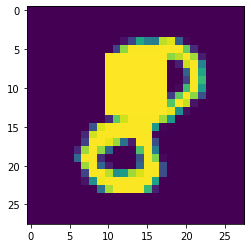

In [94]:
mask = mask_maker((28,28))
corrupted_images = original_images.numpy()[0].copy()
corrupted_images[0][1-mask > 0.5] = corrupted_images.max()
plt.imshow(corrupted_images[0])

In [95]:
mask = back_mask(corrupted_images[0], generated_images=original_images.numpy()[0][0])

C:\Users\khali\AppData\Local\Temp/ipykernel_4308/1691394351.py:4: RuntimeWarning: invalid value encountered in true_divide
  mask = corrupted_images/generated_images


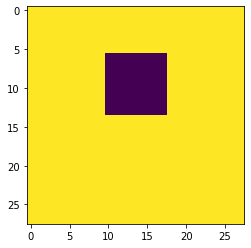

In [96]:
plt.imshow(mask)

### Phase 1

In [97]:
z_optimum = nn.Parameter(torch.FloatTensor(np.random.normal(0, 1, (batch_size,latent_dim,))).cuda())
mask_clear = MaskClear((10,10)).cuda()
optimizer_inpaint = optim.Adam([z_optimum])
optimizer_mask = optim.Adam(mask_clear.parameters())
down_sampler = nn.Upsample(size=(10,10), mode='nearest')
up_sampler = nn.Upsample(size=(28,28), mode='nearest')

C:\Users\khali\AppData\Local\Temp/ipykernel_4308/1691394351.py:4: RuntimeWarning: invalid value encountered in true_divide
  mask = corrupted_images/generated_images


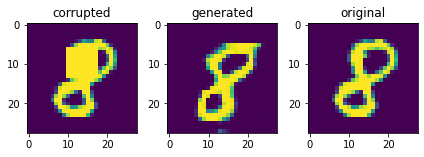

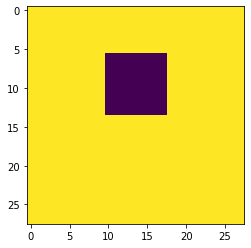

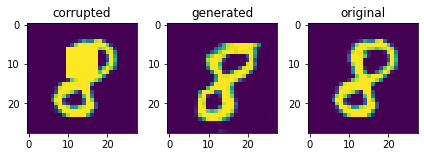

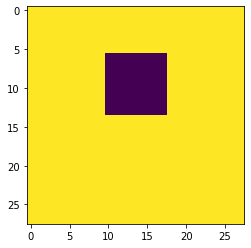

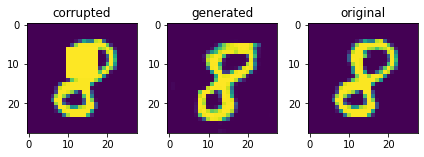

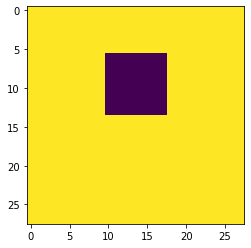

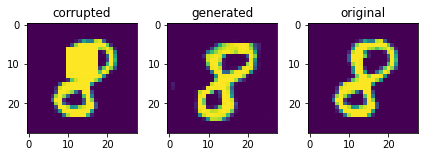

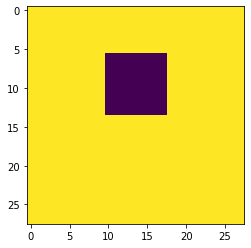

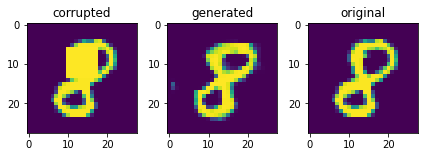

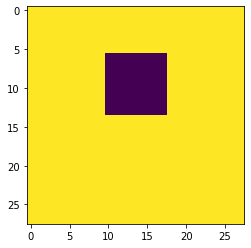

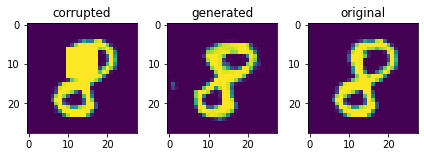

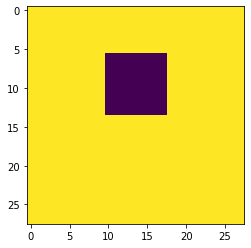

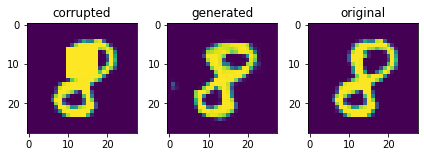

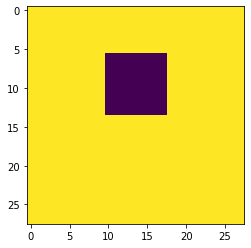

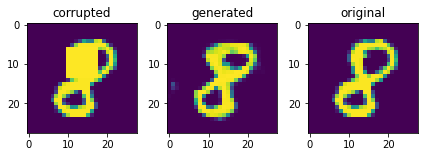

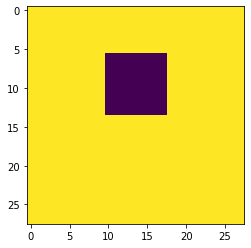

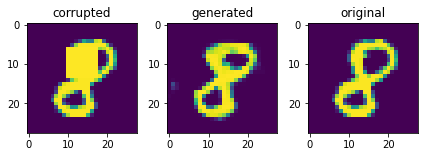

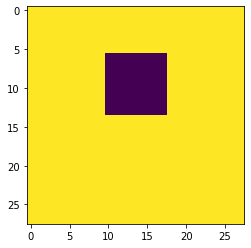

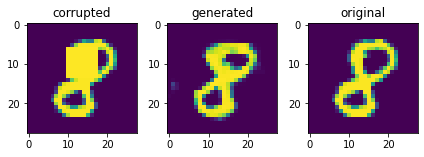

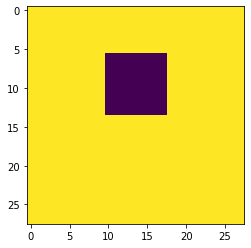

In [98]:
corrupted_images = torch.tensor(corrupted_images).view(1,1,28,28).cuda()
for epoch in range(1, 1000+1):

    # mask
    mask = back_mask(corrupted_images.detach().cpu().numpy()[0][0],
                     generated_images=original_images.numpy()[0][0])
    mask = torch.tensor(mask).view(1,1,28,28).cuda()
    mask = down_sampler(mask)
    mask = mask_clear(mask)
    mask = up_sampler(mask)
    weighted_masks = get_weighted_mask(mask[0].detach().cpu().numpy(),window_size=3)

    # z optimum
    optimizer_inpaint.zero_grad()
    optimizer_mask.zero_grad()

    generated_images = generator(z_optimum)
    discriminator_opinion = discriminator(generated_images)
    c_loss = context_loss(corrupted_images, generated_images, torch.tensor(weighted_masks).cuda())
    prior_loss = torch.sum(-torch.log(discriminator_opinion))
    inpaint_loss = c_loss + prior_loss
    inpaint_loss.backward()

    optimizer_inpaint.step()
    optimizer_mask.step()

    if epoch % 100==0:
        num_rnd = 0
        ploter(corrupted_images[num_rnd,0].detach().cpu(),
                   generated_images[num_rnd,0].detach().cpu(),
                   original_images[num_rnd,0].detach().cpu())

        plt.figure()
        mask_hat = back_mask(corrupted_images.detach().cpu().numpy()[0][0],
                     generated_images=original_images.numpy()[0][0])
        plt.imshow(mask_hat, vmin=0, vmax=1)
        plt.show()

### Phase2

In [99]:
mask = cv2.medianBlur(mask_hat, 3)
mask = mask.reshape(1,1,28,28)
mask = torch.tensor(mask)
# mask
weighted_masks = get_weighted_mask(mask[0].detach().cpu().numpy(),window_size=3)

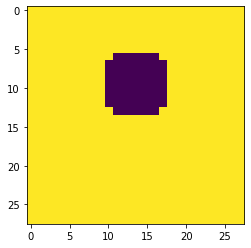

In [100]:
plt.imshow(mask[0][0])

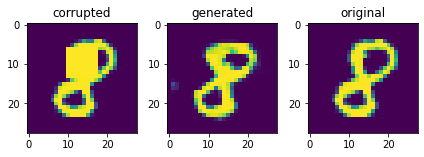

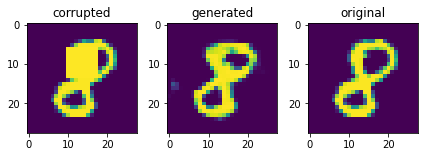

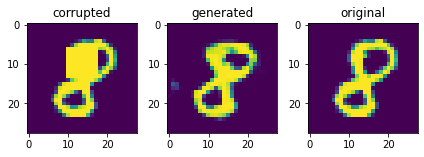

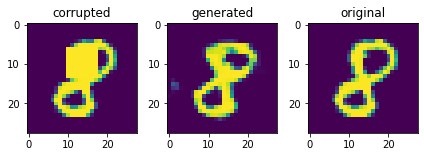

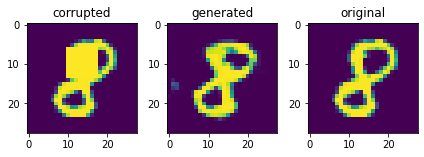

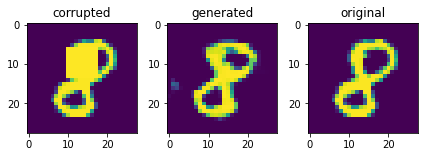

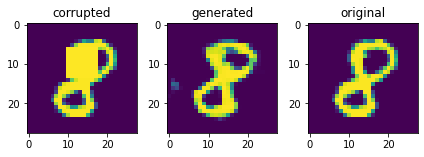

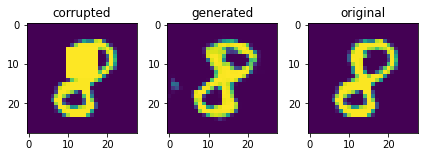

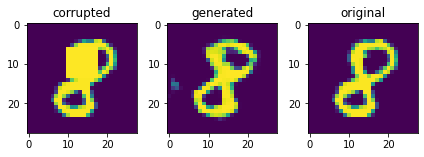

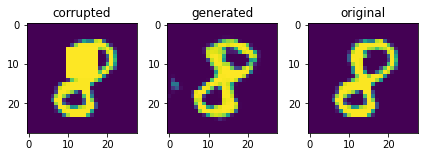

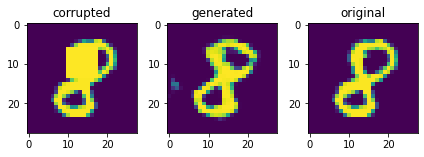

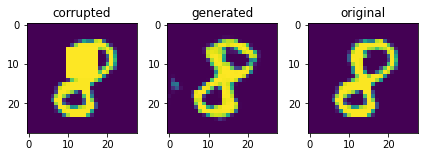

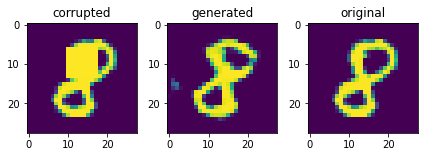

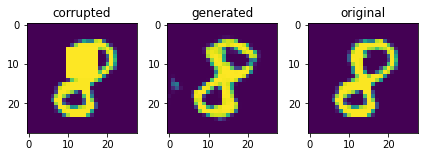

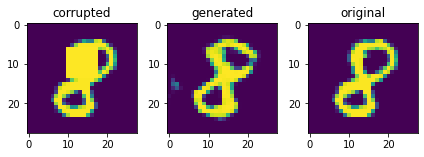

In [101]:
corrupted_images = corrupted_images.cuda()
for epoch in range(1, 1500+1):
    # z optimum
    optimizer_inpaint.zero_grad()
    generated_images = generator(z_optimum)
    discriminator_opinion = discriminator(generated_images)
    c_loss = context_loss(corrupted_images, generated_images, torch.tensor(weighted_masks).cuda())
    prior_loss = torch.sum(-torch.log(discriminator_opinion))
    inpaint_loss = c_loss + 0.003*prior_loss
    inpaint_loss.backward()

    optimizer_inpaint.step()

    if epoch % 100==0:
        num_rnd = 0
        ploter(corrupted_images[num_rnd,0].detach().cpu(),
                   generated_images[num_rnd,0].detach().cpu(),
                   original_images[num_rnd,0].detach().cpu())

### End

In [105]:
def image_gradient(image):
    a = torch.Tensor([[[[1, 0, -1],
                        [2, 0, -2],
                        [1, 0, -1]]]]).cuda()
    G_x = F.conv2d(image, a, padding=1)
    b = torch.Tensor([[[[1, 2, 1],
                        [0, 0, 0],
                        [-1, -2, -1]]]]).cuda()
    G_y = F.conv2d(image, b, padding=1)
    return G_x, G_y

In [106]:
def posisson_blending(masks,generated_images,corrupted_images):
    print("Starting Poisson blending ...")
    initial_guess = masks*corrupted_images + (1-masks)*generated_images
    image_optimum = nn.Parameter(torch.FloatTensor(initial_guess.detach().cpu().numpy()).cuda())
    optimizer_blending = optim.Adam([image_optimum])
    generated_grad_x, generated_grad_y = image_gradient(generated_images)

    for epoch in range(3000):
        optimizer_blending.zero_grad()
        image_optimum_grad_x, image_optimum_grad_y = image_gradient(image_optimum);
        blending_loss = torch.sum(((generated_grad_x-image_optimum_grad_x)**2 + (generated_grad_y-image_optimum_grad_y)**2)*(1-masks))
        blending_loss.backward()
        image_optimum.grad = image_optimum.grad*(1-masks)
        optimizer_blending.step()

        print("[Epoch: {}/{}] \t[Blending loss: {:.3f}]   \r".format(1+epoch, 3000, blending_loss), end="")
    print("")

    del optimizer_blending
    return image_optimum.detach()


In [117]:
blended_images = posisson_blending(mask[0].cuda(), generated_images.detach(), corrupted_images)

Starting Poisson blending ...
[Epoch: 3000/3000] 	[Blending loss: 45.449]   


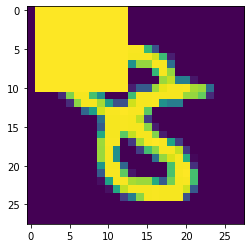

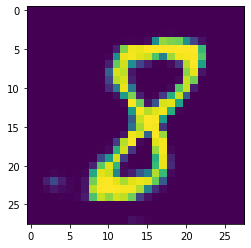

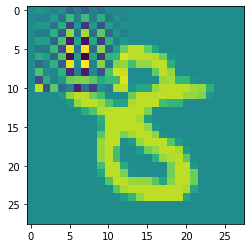

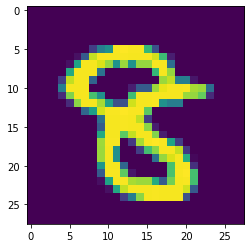

In [118]:
plt.figure()
plt.imshow(corrupted_images[0][0].detach().cpu())
plt.show()

plt.figure()
plt.imshow(generated_images[0][0].detach().cpu())
plt.show()

plt.figure()
plt.imshow(blended_images[0][0].detach().cpu())
plt.show()

plt.figure()
plt.imshow(original_images[0][0].detach().cpu())
plt.show()

In [35]:
os.getcwd()

'F:\\GitHub\\anomaly-detection\\codes\\inpairing_cvpr\\benchmark'

In [38]:
dataset = torchvision.datasets.CelebA("./Celeb/test", 'test', download=True)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

BadZipFile: File is not a zip file

In [39]:
dataset = torchvision.datasets.CelebA("./Celeb/train", 'train', download=True)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

BadZipFile: File is not a zip file

In [40]:
dataset

NameError: name 'dataset' is not defined